In [ ]:
 
#  Setup & Imports
 

import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

print(" Libraries loaded successfully!")

 
#   CONFIGURATION
 
DATASET_DIR = "/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage"  
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0      
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("  Device:", DEVICE)
print(" Dataset path:", DATASET_DIR)

 
 
# Preprocessing for ResNet/EfficientNet Feature Extraction
 
feature_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

print("  Transform pipeline created.")


 Libraries loaded successfully!
  Device: cuda
 Dataset path: /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage
  Transform pipeline created.


Total images in dataset: 14529
Number of classes: 10
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

Split sizes:
 Train: 10170
 Val  : 2179
 Test : 2180

Batches -> train: 318 | val: 69 | test: 69
Batch size: 32

Class counts (Train / Val / Test):
Tomato___Bacterial_spot                  Train:1191  Val: 255  Test: 256
Tomato___Early_blight                    Train: 560  Val: 120  Test: 120
Tomato___Late_blight                     Train:1069  Val: 229  Test: 229
Tomato___Leaf_Mold                       Train: 533  Val: 114  Test: 114
Tomato___Septoria_leaf_spot              Train: 992  Val: 212  Test: 213
Tomato___Spider_mites Two-spotted_spider_mite Train: 939  Val: 201  Test: 201
Tomato___Target_Spot                     Train: 7

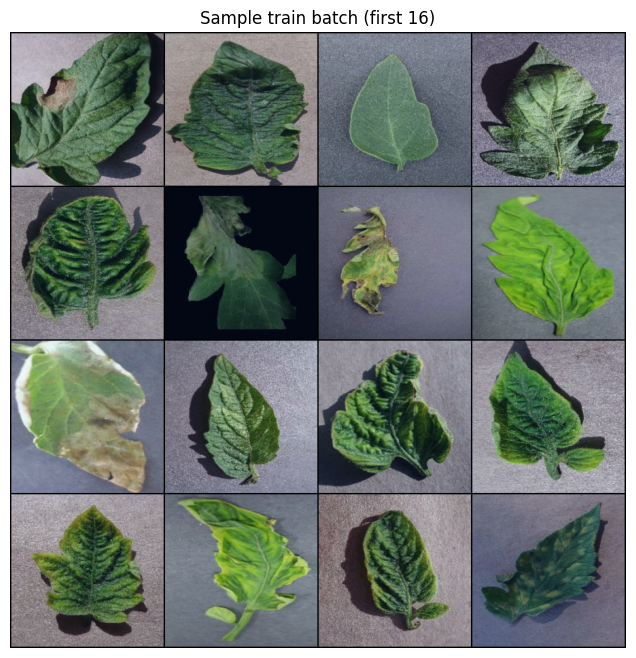


 DataLoaders and splits ready.


In [ ]:
 
#   Train / Val / Test splits + DataLoaders
 

import random
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import Subset

# reproducible
RND_SEED = 42
random.seed(RND_SEED)
np.random.seed(RND_SEED)
torch.manual_seed(RND_SEED)

 
full_dataset = ImageFolder(DATASET_DIR, transform=feature_transform)
num_samples = len(full_dataset)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Total images in dataset: {num_samples}")
print(f"Number of classes: {num_classes}")
print("Classes:", class_names)

 
all_indices = list(range(num_samples))
all_targets = [s[1] for s in full_dataset.samples]  

 
train_idx, temp_idx, y_train, y_temp = train_test_split(
    all_indices, all_targets,
    test_size=0.30,
    stratify=all_targets,
    random_state=RND_SEED
)
 
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RND_SEED
)

 
print("\nSplit sizes:")
print(f" Train: {len(train_idx)}")
print(f" Val  : {len(val_idx)}")
print(f" Test : {len(test_idx)}")

 
train_set = Subset(full_dataset, train_idx)
val_set   = Subset(full_dataset, val_idx)
test_set  = Subset(full_dataset, test_idx)

 
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=='cuda'))
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=='cuda'))
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=='cuda'))

print("\nBatches -> train:", len(train_loader), "| val:", len(val_loader), "| test:", len(test_loader))
print("Batch size:", BATCH_SIZE)

 
from collections import Counter
def idx_label_counts(indices):
    labels = [full_dataset.samples[i][1] for i in indices]
    c = Counter(labels)
   
    return {full_dataset.classes[k]: c.get(k,0) for k in range(len(full_dataset.classes))}

print("\nClass counts (Train / Val / Test):")
train_counts = idx_label_counts(train_idx)
val_counts = idx_label_counts(val_idx)
test_counts = idx_label_counts(test_idx)
for cls in class_names:
    print(f"{cls:40s} Train:{train_counts[cls]:4d}  Val:{val_counts[cls]:4d}  Test:{test_counts[cls]:4d}")

 
batch = next(iter(train_loader))
imgs, labels = batch
print("\nImages tensor shape:", imgs.shape)
print("Labels tensor shape:", labels.shape)

 
grid = make_grid(imgs[:16], nrow=4, normalize=True) 
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.title("Sample train batch (first 16)")
plt.show()

 
__all_splits = {"train_idx":train_idx, "val_idx":val_idx, "test_idx":test_idx,
                "train_set":train_set, "val_set":val_set, "test_set":test_set,
                "train_loader":train_loader, "val_loader":val_loader, "test_loader":test_loader,
                "class_names":class_names}
print("\n DataLoaders and splits ready.")


In [ ]:
 
#  Extract deep features from ResNet-50 for SVM
 

import torch
import torch.nn as nn
from tqdm import tqdm

# Load pretrained ResNet-50
resnet = models.resnet50(weights="IMAGENET1K_V1")
resnet.fc = nn.Identity()      
resnet = resnet.to(DEVICE)
resnet.eval()

print(" ResNet-50 loaded (feature extractor mode)")


# Function: extract features from a dataloader
def extract_features(dloader):
    feat_list = []
    label_list = []

    with torch.no_grad():
        for imgs, labels in tqdm(dloader, desc="Extracting"):
            imgs = imgs.to(DEVICE)

            feats = resnet(imgs)          
            feats = feats.cpu().numpy()

            feat_list.append(feats)
            label_list.append(labels.numpy())

    return np.concatenate(feat_list), np.concatenate(label_list)


# ---- Extract Train / Val / Test Features ----
train_feats, train_labels = extract_features(train_loader)
val_feats,   val_labels   = extract_features(val_loader)
test_feats,  test_labels  = extract_features(test_loader)


# ---- Save to disk ----
np.save("/kaggle/working/train_features.npy", train_feats)
np.save("/kaggle/working/train_labels.npy", train_labels)

np.save("/kaggle/working/val_features.npy", val_feats)
np.save("/kaggle/working/val_labels.npy", val_labels)

np.save("/kaggle/working/test_features.npy", test_feats)
np.save("/kaggle/working/test_labels.npy", test_labels)

print("\n  Feature extraction complete!")
print("Saved:")
print("  train_features.npy, train_labels.npy")
print("  val_features.npy, val_labels.npy")
print("  test_features.npy, test_labels.npy")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s] 


 ResNet-50 loaded (feature extractor mode)


Extracting: 100%|██████████| 69/69 [00:24<00:00,  2.85it/s]


  Feature extraction complete!
Saved:
  train_features.npy, train_labels.npy
  val_features.npy, val_labels.npy
  test_features.npy, test_labels.npy


In [7]:
# === Train SVM on extracted features ===

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib

print("Loading saved feature files...")

train_feats = np.load("/kaggle/working/train_features.npy")
train_labels = np.load("/kaggle/working/train_labels.npy")

val_feats   = np.load("/kaggle/working/val_features.npy")
val_labels  = np.load("/kaggle/working/val_labels.npy")

test_feats  = np.load("/kaggle/working/test_features.npy")
test_labels = np.load("/kaggle/working/test_labels.npy")

print("Shapes:")
print(" Train:", train_feats.shape, train_labels.shape)
print(" Val:  ", val_feats.shape, val_labels.shape)
print(" Test: ", test_feats.shape, test_labels.shape)


# === Train SVM   ===
print("\nTraining SVM...")

svm_model = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    probability=True
)

svm_model.fit(train_feats, train_labels)

print("SVM training complete!")

# === Validation performance ===
val_pred = svm_model.predict(val_feats)
val_acc = accuracy_score(val_labels, val_pred) * 100
print(f"\nValidation Accuracy: {val_acc:.2f}%")

# === Test performance ===
test_pred = svm_model.predict(test_feats)
test_acc = accuracy_score(test_labels, test_pred) * 100
print(f"Test Accuracy: {test_acc:.2f}%\n")

print("Classification Report:")
print(classification_report(test_labels, test_pred, target_names=class_names))

# Save model
joblib.dump(svm_model, "/kaggle/working/svm_resnet_model.pkl")
print("\nSaved: svm_resnet_model.pkl")


Loading saved feature files...
Shapes:
 Train: (10170, 2048) (10170,)
 Val:   (2179, 2048) (2179,)
 Test:  (2180, 2048) (2180,)

Training SVM...
SVM training complete!

Validation Accuracy: 97.71%
Test Accuracy: 97.16%

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       1.00      1.00      1.00       256
                        Tomato___Early_blight       0.90      0.87      0.89       120
                         Tomato___Late_blight       0.96      0.96      0.96       229
                           Tomato___Leaf_Mold       0.96      0.96      0.96       114
                  Tomato___Septoria_leaf_spot       0.95      0.98      0.97       213
Tomato___Spider_mites Two-spotted_spider_mite       0.95      0.96      0.95       201
                         Tomato___Target_Spot       0.92      0.93      0.93       168
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00    

Loaded SVM: SVC
Number of classes = 10
Using decision_function output as scores.
Micro AUC:  0.9973
Macro AUC:  0.9959


/tmp/ipykernel_48/2096213038.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", n_classes)


Saved ROC curves -> /kaggle/working/roc_curves.png


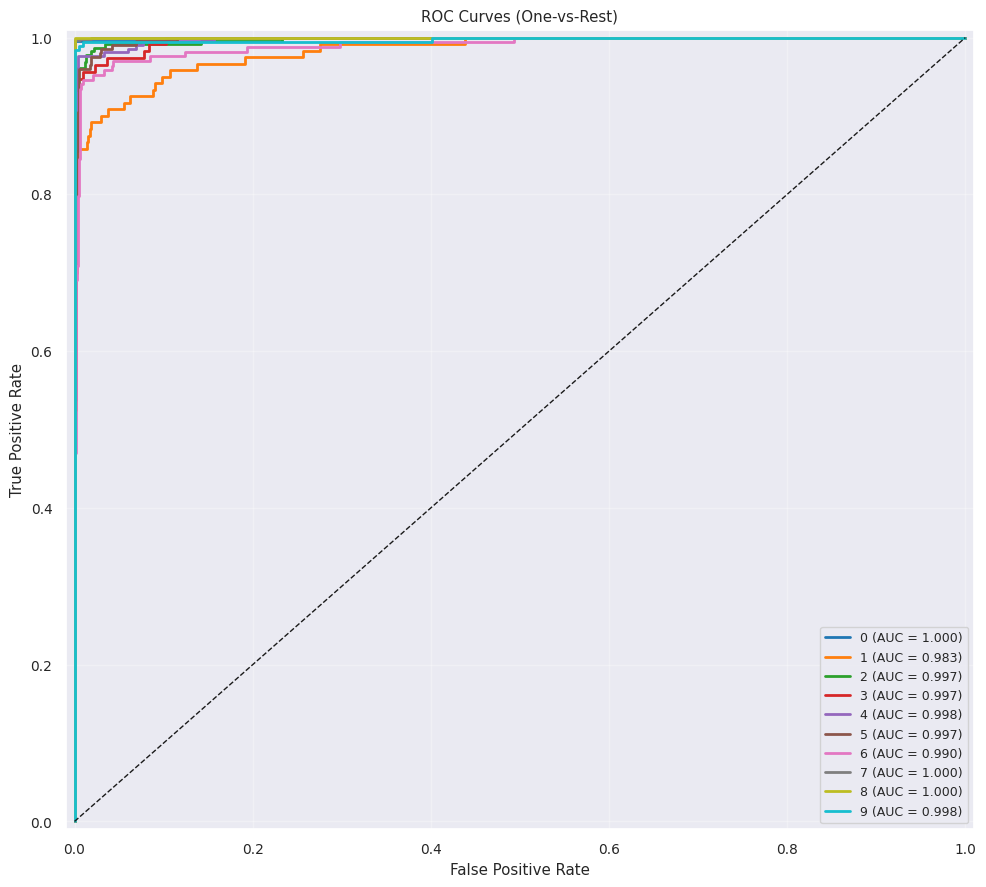

In [ ]:
#   SVM model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib
import os

# ---- Paths   ----
TEST_FEATS_PATH = "/kaggle/working/test_features.npy"
TEST_LABELS_PATH = "/kaggle/working/test_labels.npy"
SVM_MODEL_PATH  = "/kaggle/working/svm_resnet_model.pkl"
ROC_OUT_PATH    = "/kaggle/working/roc_curves.png"

# ---- Load data & model ----
if not os.path.exists(TEST_FEATS_PATH) or not os.path.exists(TEST_LABELS_PATH):
    raise FileNotFoundError("Missing test_features.npy or test_labels.npy in /kaggle/working. Run feature extraction first.")

test_feats = np.load(TEST_FEATS_PATH)
test_labels = np.load(TEST_LABELS_PATH)

if not os.path.exists(SVM_MODEL_PATH):
    raise FileNotFoundError(f"Saved SVM model not found at: {SVM_MODEL_PATH}")

svm_model = joblib.load(SVM_MODEL_PATH)
print("Loaded SVM:", type(svm_model).__name__)

# ---- get class names ----
try:
    class_names   
except NameError:
    
    try:
        class_names = np.load("/kaggle/working/class_names.npy", allow_pickle=True)
        class_names = list(class_names)
    except Exception:
     
        n_classes = len(np.unique(test_labels))
        class_names = [f"class_{i}" for i in range(n_classes)]
        print("Warning: class_names not found in notebook or on disk. Using numeric class names.")

n_classes = len(class_names)
print(f"Number of classes = {n_classes}")

# ---- get score matrix  ----
if hasattr(svm_model, "decision_function"):
    try:
        scores = svm_model.decision_function(test_feats)
        print("Using decision_function output as scores.")
    except Exception as e:
        print("decision_function failed:", e)
        if hasattr(svm_model, "predict_proba"):
            scores = svm_model.predict_proba(test_feats)
            print("Using predict_proba as fallback.")
        else:
            raise RuntimeError("Model has no usable scoring method (decision_function/predict_proba).")
elif hasattr(svm_model, "predict_proba"):
    scores = svm_model.predict_proba(test_feats)
    print("Using predict_proba output as scores.")
else:
    raise RuntimeError("Model doesn't support decision_function or predict_proba. Re-train with probability=True or use a classifier that provides scores.")

 
if scores.ndim == 1:
    
    scores = np.vstack([ -scores, scores ]).T

# ---- binarize true labels ----
y_test_bin = label_binarize(test_labels, classes=np.arange(n_classes))
if y_test_bin.shape[1] != n_classes:
 
    unique = np.unique(test_labels)
    if len(unique) == n_classes:
        mapping = {v:i for i,v in enumerate(unique)}
        mapped = np.array([mapping[v] for v in test_labels])
        y_test_bin = label_binarize(mapped, classes=np.arange(n_classes))
    else:
        raise RuntimeError("Mismatch between class_names length and test labels.")

# ---- compute ROC and AUC per class ----
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

 
from sklearn.metrics import roc_auc_score
try:
    roc_auc_micro = roc_auc_score(y_test_bin, scores, average="micro", multi_class="ovr")
    roc_auc_macro = roc_auc_score(y_test_bin, scores, average="macro", multi_class="ovr")
except Exception:
    # fallback 
    roc_auc_micro = roc_auc_score(y_test_bin.ravel(), scores.ravel())
    roc_auc_macro = np.mean(list(roc_auc.values()))

print(f"Micro AUC:  {roc_auc_micro:.4f}")
print(f"Macro AUC:  {roc_auc_macro:.4f}")

# ---- Plot ROC curves ----
plt.figure(figsize=(10, 9))
colors = plt.cm.get_cmap("tab10", n_classes)

for i, cname in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors(i),
             label=f"{cname} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right", fontsize="small")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(ROC_OUT_PATH, dpi=150)
print("Saved ROC curves ->", ROC_OUT_PATH)
plt.show()


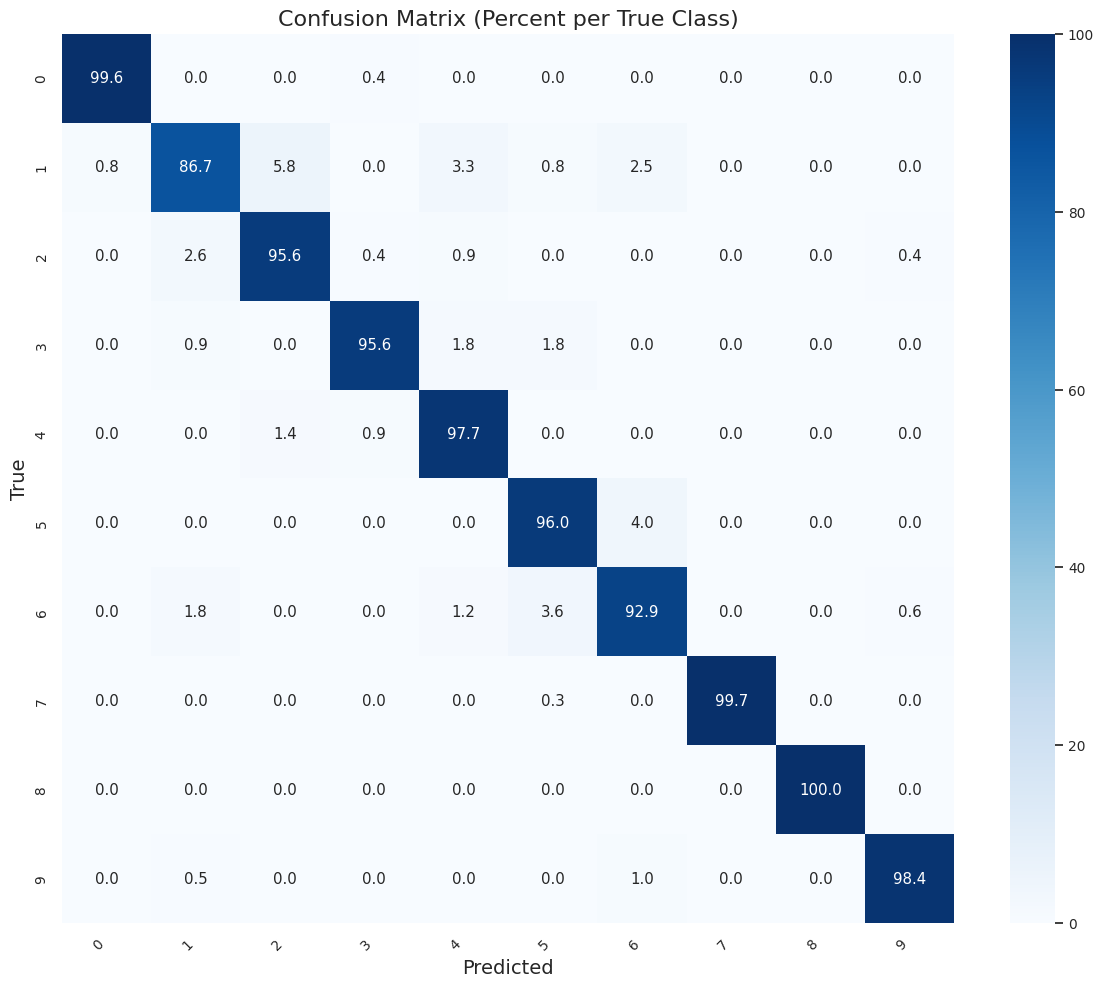

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---- Load test data ----
test_feats = np.load("/kaggle/working/test_features.npy")
test_labels = np.load("/kaggle/working/test_labels.npy")

# ---- Reload trained SVM model ----
import joblib
svm_model = joblib.load("/kaggle/working/svm_resnet_model.pkl")

# ---- Generate predictions ----
test_pred = svm_model.predict(test_feats)

# ---- Build confusion matrix ----
cm = confusion_matrix(test_labels, test_pred)

# ---- Convert to % ----
cm_percent = (cm.T / cm.sum(axis=1)).T * 100

# ---- Plot ----
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.title("Confusion Matrix (Percent per True Class)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Loading files...
Predicting...
Total misclassified images: 62


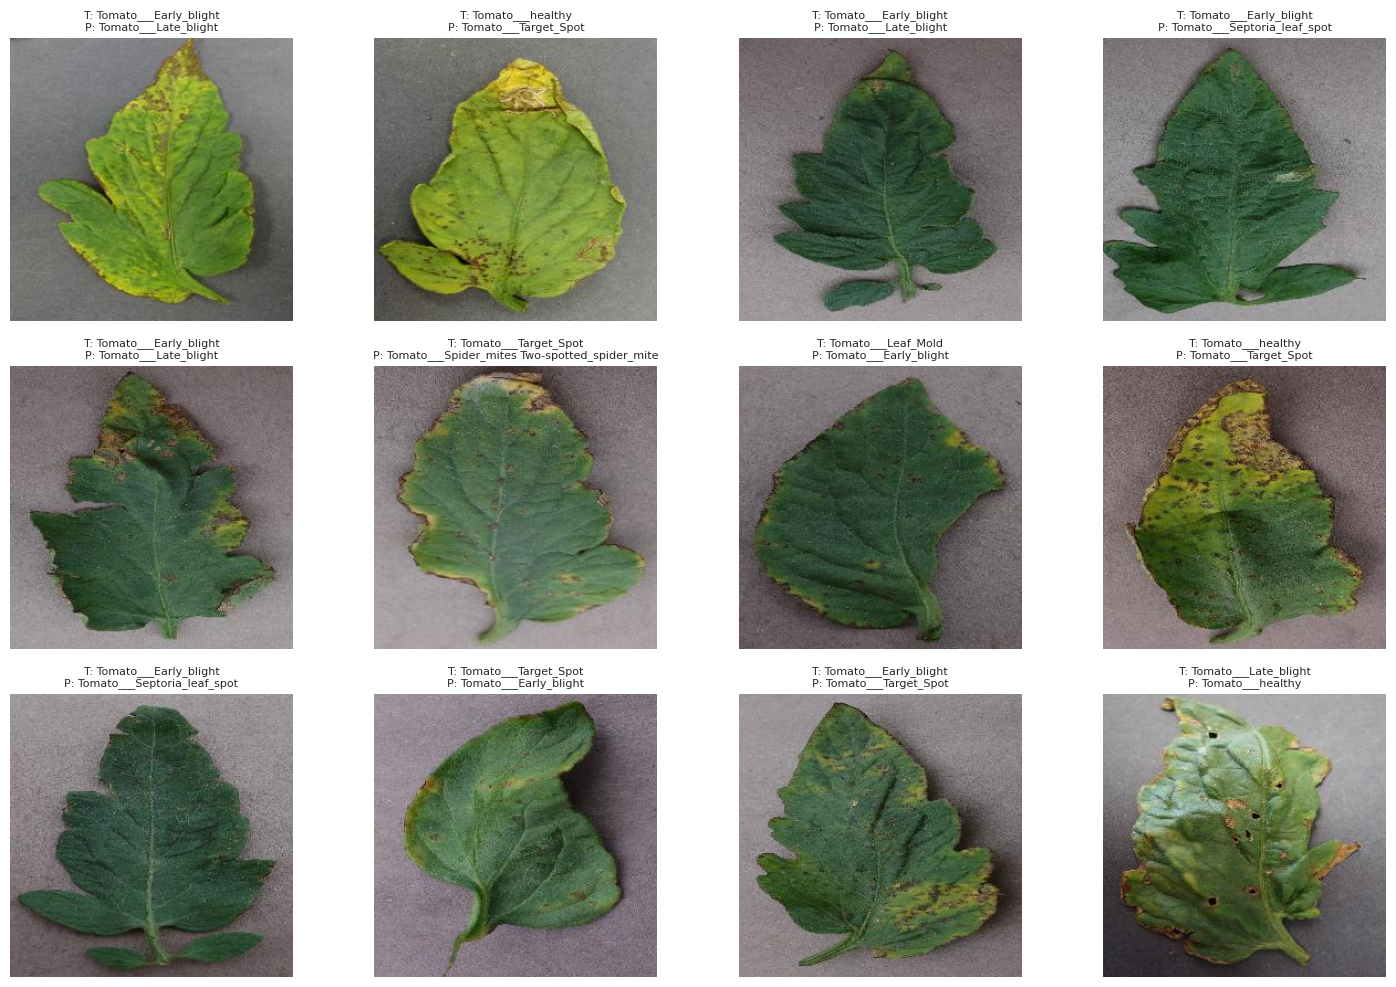

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import joblib
import torch
from torchvision import models, transforms
import os

print("Loading files...")

# Load saved feature arrays  
test_feats = np.load("/kaggle/working/test_features.npy")
test_labels = np.load("/kaggle/working/test_labels.npy")

# Load SVM model
svm_model = joblib.load("/kaggle/working/svm_resnet_model.pkl")

# Class names
class_names = [
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 
    'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',  
    'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

print("Predicting...")
test_pred = svm_model.predict(test_feats)

# Find misclassified indexes
mis_idx = np.where(test_pred != test_labels)[0]

print(f"Total misclassified images: {len(mis_idx)}")

# If no misclassification
if len(mis_idx) == 0:
    print(" No misclassifications  ")
else:
    # Load original dataset folder
    ROOT = "/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage"

    # Collect all image paths for test set
    img_paths = []

    for cls in class_names:
        folder = os.path.join(ROOT, cls)
        files = sorted(os.listdir(folder))
        img_paths.extend([os.path.join(folder, f) for f in files])

    # Show first 12 misclassified images
    N = min(12, len(mis_idx))
    plt.figure(figsize=(15, 10))

    for i in range(N):
        idx = mis_idx[i]
        
        # Load image
        img = Image.open(img_paths[idx]).convert("RGB")

        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.axis("off")

        true = class_names[test_labels[idx]]
        pred = class_names[test_pred[idx]]

        plt.title(f"T: {true}\nP: {pred}", fontsize=8)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Selecting one image from each class...
Total selected: 10


/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_48/717329350.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


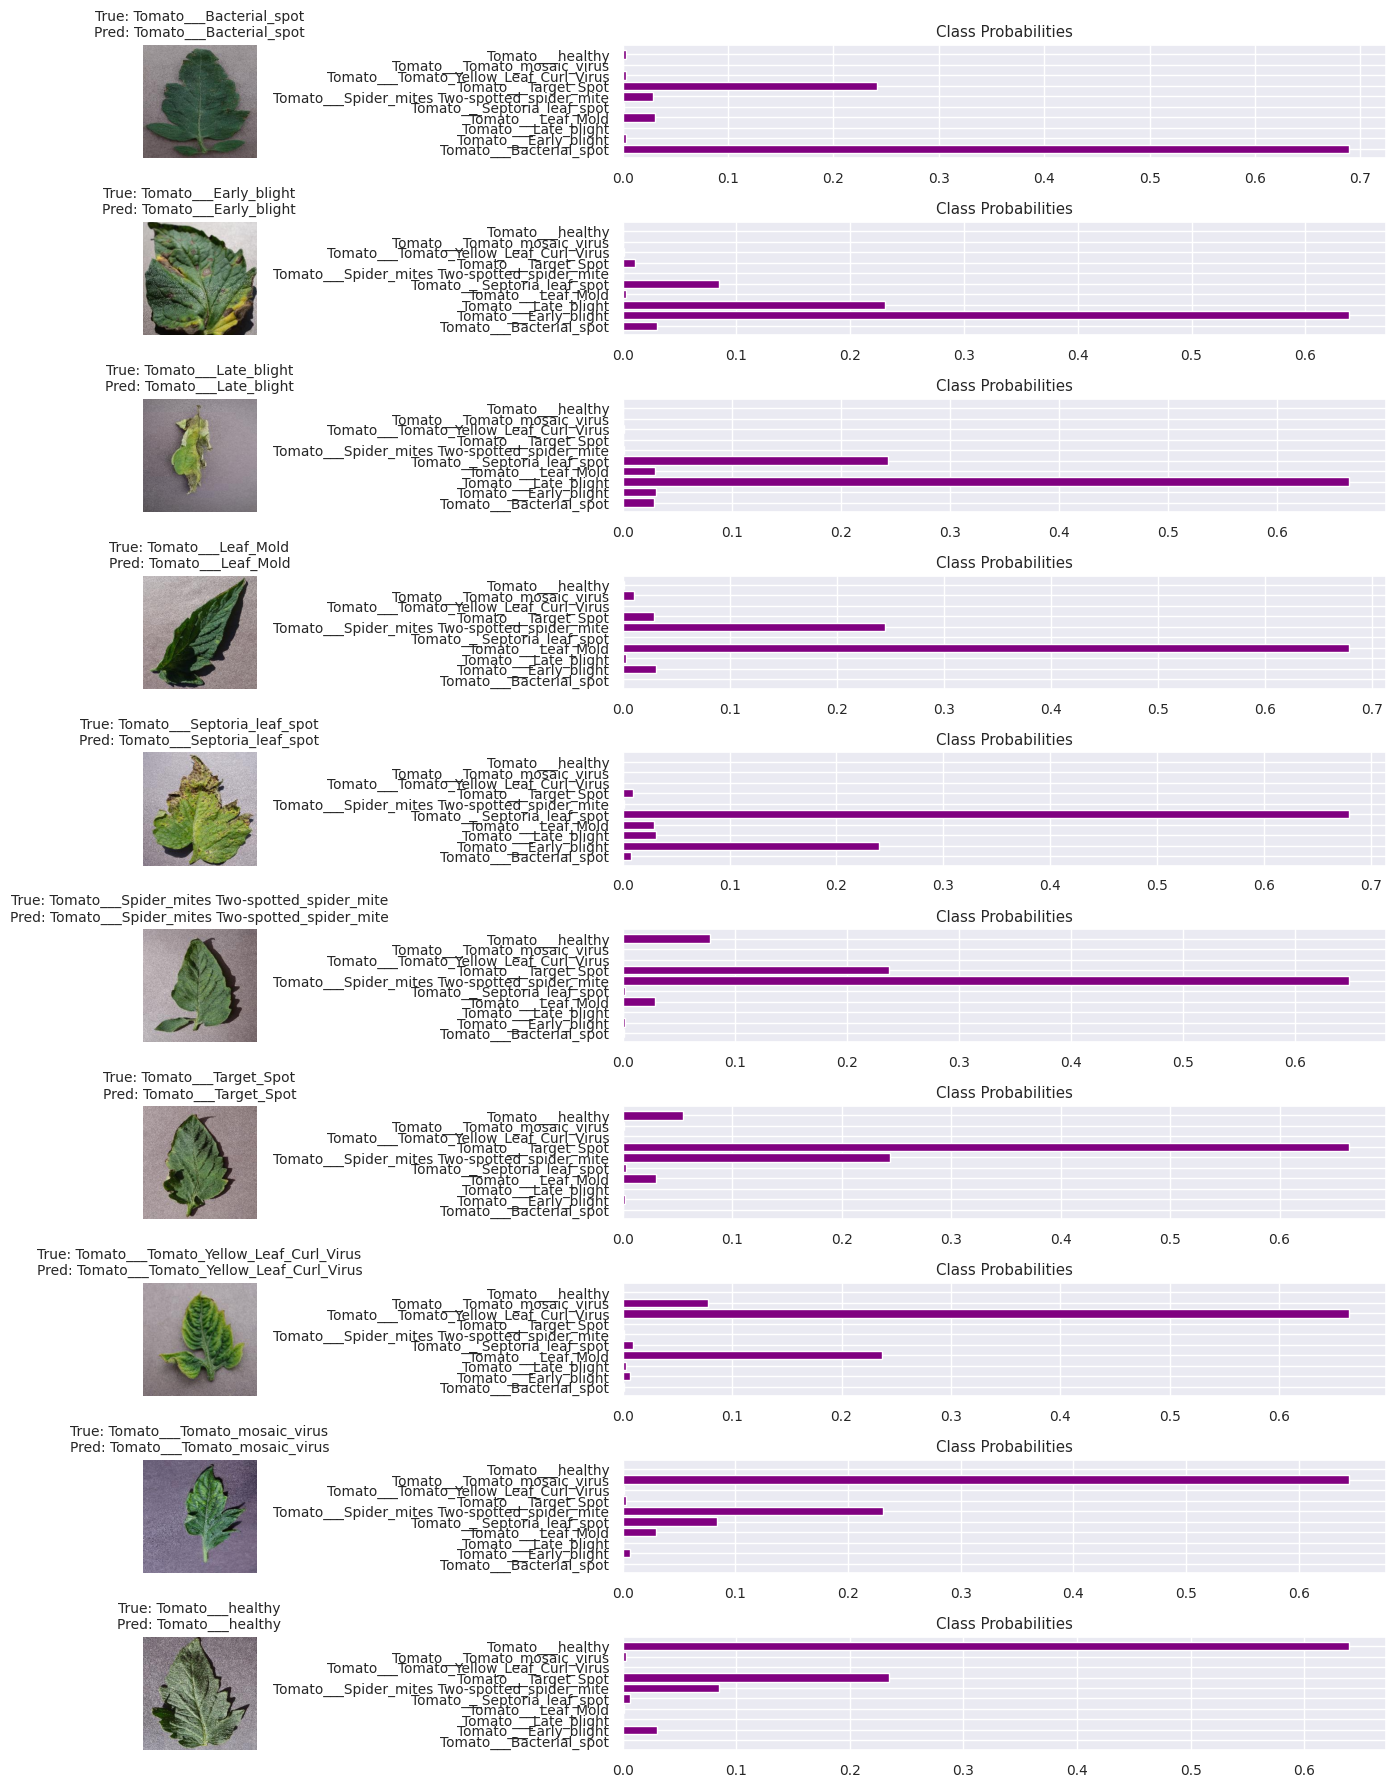

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import joblib
import torch
from torchvision import models, transforms

# Paths  
ROOT = "/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage"
SVM_MODEL_PATH = "/kaggle/working/svm_resnet_model.pkl"

# Class names 
class_names = [
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 
    'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',  
    'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

# Load SVM Model 
svm_model = joblib.load(SVM_MODEL_PATH)

# ResNet50 feature extractor 
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()      
resnet = resnet.to(device)
resnet.eval()

# Transform for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("Selecting one image from each class...")

#   1 random image per class 
samples = []
for cls in class_names:
    folder = os.path.join(ROOT, cls)
    imgs = os.listdir(folder)
    img_name = random.choice(imgs)
    samples.append(os.path.join(folder, img_name))

print("Total selected:", len(samples))

#  Predict all selected images  
plt.figure(figsize=(16, 18))

for i, img_path in enumerate(samples):
    # Load image
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    # Extract features
    with torch.no_grad():
        feat = resnet(img_t).cpu().numpy()

    # Predict using SVM
    pred = svm_model.predict(feat)[0]
    probs = svm_model.decision_function(feat)
    # Convert to probability-like scale
    probs = np.exp(probs) / np.sum(np.exp(probs))

    true_class = os.path.basename(os.path.dirname(img_path))
    pred_class = class_names[pred]

    # Show image 
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
    plt.axis("off")

    # Show confidence bar 
    plt.subplot(10, 2, 2*i + 2)
    plt.barh(class_names, probs[0], color="purple")
    plt.title("Class Probabilities")
    plt.tight_layout()

plt.show()
